In [1]:
"""
Выберите ряд и постройте его модель GARCH.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from arch import arch_model
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Инициируем временной ряд
# series = pd.read_csv('international-airline-passengers.csv').dropna().values[:, 1]
series = pd.read_csv('international-airline-passengers.csv')
series

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
# посмотрим, есть ли пустые значения столбца Count: нет 
series['Count'].isnull().any()

False

In [4]:
# Инициализируем функцию тестирования ряда на стационарность
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
# инициализируем функцию, выводящую информацию в графической форме
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Результаты теста Дики-Фуллера:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


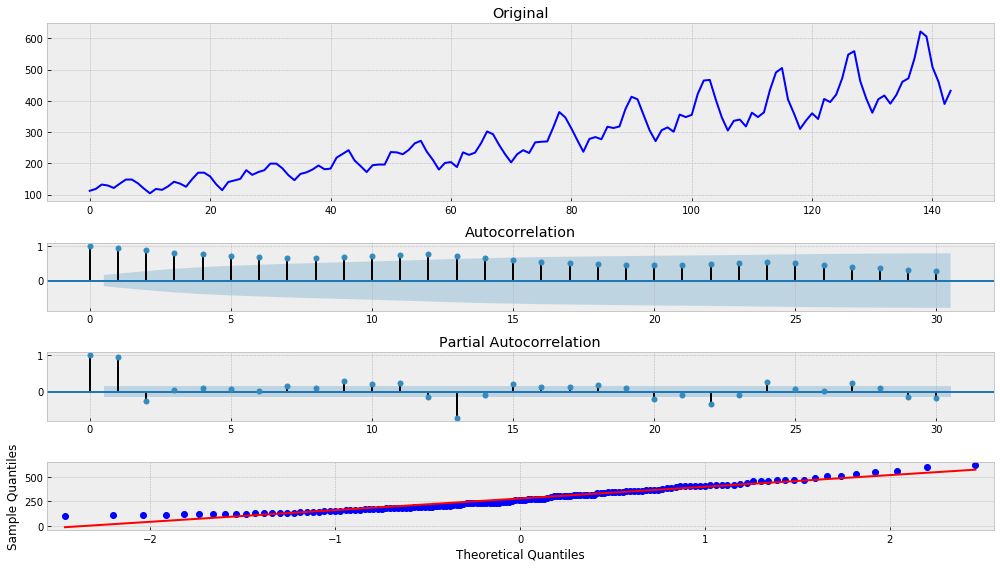

In [6]:
# тест демонстрирует, что ряд не является стационарным, график демонстрирует сезонность, тренд и различающуюся дисперсию:
# потребуется его нормализовать
tsplot(series['Count'], lags=30)

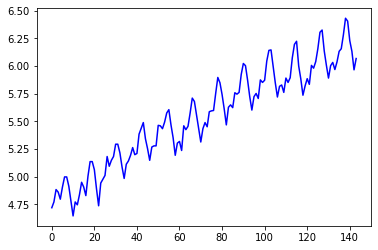

In [7]:
# нормализуем временной ряд
# Произведем преобразование методом Бокса-Кокса, чтобы исключить разницу дисперсий
# Визуально видим, что это удалось 
series = boxcox(series['Count'], 0)
plt.plot(series, color='blue')
plt.show()

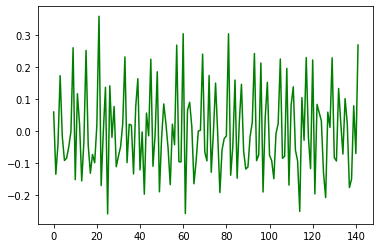

In [8]:
# далее избавимся от тренда 
series = np.diff(series, 2)
plt.plot(series, color='green')
plt.show()

Результаты теста Дики-Фуллера:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


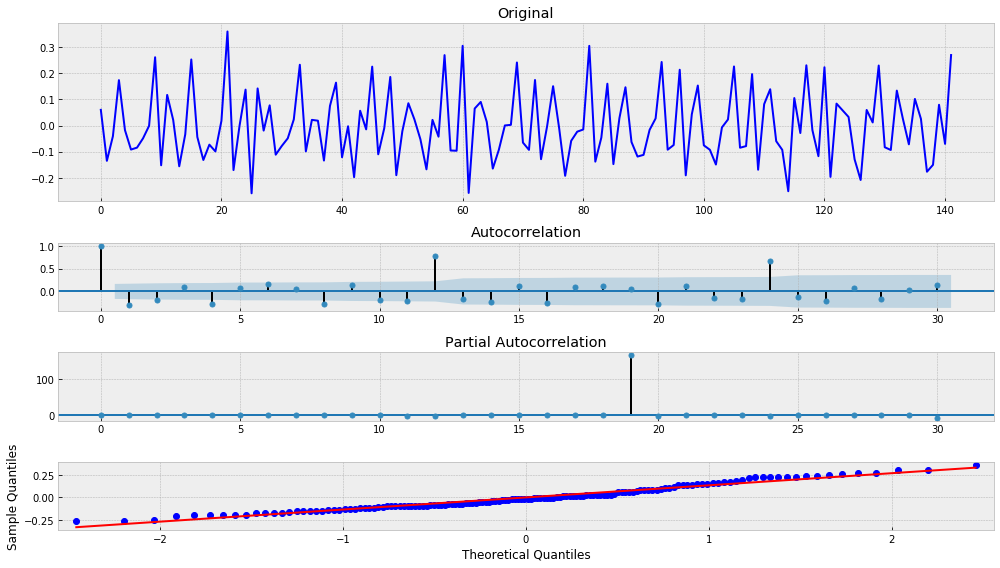

In [9]:
# Протестируем график снова: статистика дает число -10.21508, которое левее критического значения => ряд стационарен 
tsplot(series, lags=30)

In [12]:
# Побберем параметры для модель, используя метод ARIMA
# Для этого инициализируем функцию подбора параметров
def get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [11]:
get_best_model(series)

aic: -294.55920 | order: (4, 0, 4)


(-294.5591959445683,
 (4, 0, 4),
 <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x2bea8a2f488>)

Результаты теста Дики-Фуллера:
Test Statistic                  -2.257587
p-value                          0.186012
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


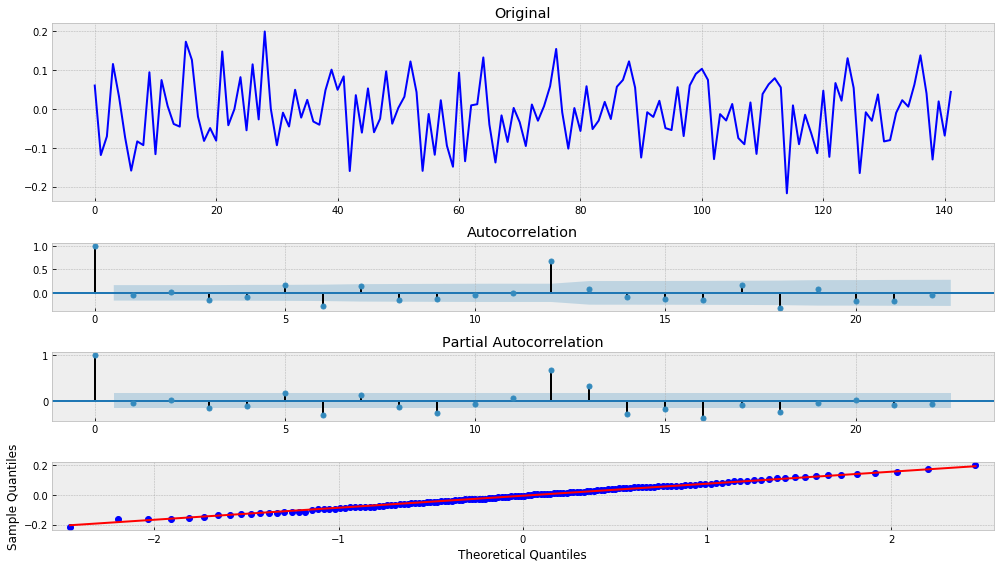

In [13]:
tsplot(mdl.resid)  # свойство resid хранит остатки модели

# в модели видим определенную сезонность и некоторые проявления тренда
# (на графике частичной автокорреляции) 
# ряд не является абсолютно нормализованным, однако распределение остатков близко к нормальному,
# что свидетельствует: с рядом можно работать как со стационарным

In [17]:
# перейдем к построению модели GARCH
series = series[12:] - series[:-12]  # за счет разницы с лагом 12 исключаем влияние сезонности 
series = series[1:] - series[:-1]    # за счет разницы с лагом 1 исключаем влияние тренда

In [18]:
# теперь подгоним модель arch, применив наиболее подходящие параметры 
# Видим, что большое влияение на модель оказывает первая альфа, остальные нули 
p=4
d=0
q=4

am = arch_model(series, vol='Garch', p=p, o=d, q=q, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:                99.0200
Distribution:      Standardized Student's t   AIC:                          -176.040
Method:                  Maximum Likelihood   BIC:                          -144.582
                                              No. Observations:                  129
Date:                      Sat, Jul 24 2021   Df Residuals:                      118
Time:                              17:14:54   Df Model:                           11
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [20]:
forecast = res.forecast(horizon=3) # Прогнозы с более длинным горизонтом можно рассчитать, передав параметр horizon
                                    # по умолчанию горизонт равен 1
print(forecast)

In [ ]:
# Документация по ARCH: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html?highlight=disp#Value-at-Risk-Forecasting
# Документация по ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html